# Week 14: Fitting

## Objectives:
* Cover performance and syntax for general unbinned fitting.

Remember to `pip install probfit` (`--user` if you are not in a virtual environment). `cupy` is used at the end; you'll need `conda install cupy` in an environment. Times are from a 24 core Xeon with a Titan V.

We will put our preperation code in a file, and restart the kernel as we go, just to make sure we don't have any interaction between GPU libraries. `likelyhood_answer` is defined to be the numpy value - Note that the reduction can produce lots of round of error if not done properly. I know numpy does, not sure about probfit.

#### Results: 
    
| Package   | Hardware      | Time per call | Minimize time |
|-----------|---------------|---------------|---------------|
| Probfit   | 24 core Zeon  | 1.11 s        | 2.23 min      |
| Numpy     | 24 core Zeon  | 21.1 ms       | 2.38 s        |
| Numba parallel | 24 core Zeon | 11.5 ms   | 1.46 s        |
| Numba parallel loop | 24 core Zeon | 3.68 ms | 416 ms     |
| GooFit    | Titan V       | 2.30 ms       | 333 ms        |
| CUPY      | Titan V       | 2.9 ms        | 491 ms        |
| CUPY kernel | Titan V     | 843 µs        | 118 ms        |
| CUPY redu | Titan V       | 2.50 ms       | 343 ms        |
| PyTorch   | Titan V       | 3.68 ms       | 594 ms        |
| TensorFlow static | Titan V | 1.38 ms     | 225 ms        |


In [3]:
# it seems read_pretty does not exist anymore
# from read_pretty import read_pretty
# read_pretty('common.py')
!cat common.py

import numpy as np
from iminuit import Minuit
import math

np.random.seed(42)

dist = np.hstack([
    np.random.normal(loc=1, scale=2., size=500_000),
    np.random.normal(loc=1, scale=.5, size=500_000)
])

default_params = dict(
    f_0=.5,
    error_f_0=.01,
    limit_f_0=(0,1),

    mean=1.5,
    error_mean=.01,
    limit_mean=(-10,10),

    sigma=.4,
    limit_sigma=(0,1),
    error_sigma=.01,

    sigma2=3.,
    error_sigma2=.01,
    limit_sigma2=(1,3),
)


class Compare:
    def __init__(self, value):
        self.value = value
        
    def __eq__(self, other):
        if other == self.value:
            return True
        
        frac = abs(other - self.value) / self.value
        print(f'Missed by: {frac:.3}')
        return frac < .00001

likelyhood_answer = Compare(4976157.922404283)

def run_and_print(minuit):
    minuit.print_level=0
    a,b = minuit.migrad()
    print("FCN: {nfcn}\nis_valid: {is_valid}\nfval: {fval}\nedm: {edm}\n".format(**a))

## Make data

First, we make our data. It's a simple double gaussian with no background.

In [2]:
%run common.py

In [4]:
import matplotlib.pyplot as plt

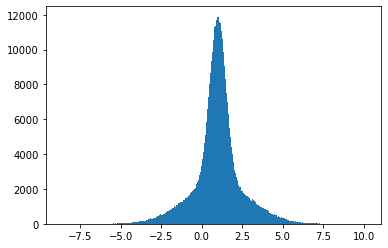

In [5]:
plt.hist(dist, bins='auto');

## Probfit

Now, let's try using probfit to fit the data. First, we have to rename the parameters - probfit merges similar named parameters. I already know that gaussian comes with `x`, `mean`, and `sigma`. We use `AddPdfNorm` to add the pdfs, and they are kept normalized. A new parameter is added, `f_0`.

In [6]:
import probfit

ModuleNotFoundError: No module named 'probfit'

In [ ]:
second_gaussian = probfit.rename(probfit.gaussian, ["x", "mean", "sigma2"])
pdf_function = probfit.AddPdfNorm(probfit.gaussian, second_gaussian)

Now, let's build an unbinned likelyhood function:

In [ ]:
unbinned_lh = probfit.UnbinnedLH(pdf_function, dist)

In [ ]:
assert unbinned_lh(.5,.5,.5,.5) == likelyhood_answer

In [ ]:
%%timeit
unbinned_lh(*np.random.rand(4))

We have to use iMinuit's name based parameter setting interface:

In [ ]:
minuit = Minuit(unbinned_lh, **default_params)

And let's do the fit!

In [ ]:
%%time
run_and_print(minuit)

In [ ]:
unbinned_lh.draw(minuit);

In [ ]:
exit()

## GooFit

Let's try that in GooFit. We set up our model in what I view as a more readable but more verbose way:

In [ ]:
%run common.py

In [ ]:
import goofit

In [ ]:
goofit.GOOFIT_DEVICE

In [ ]:
x = goofit.Observable('x', -10, 10)

ds = goofit.UnbinnedDataSet(x)
ds.from_matrix([dist], filter=True)

mean = goofit.Variable('mean', 1.5, -10, 10)
sigma = goofit.Variable('sigma', .4, 0, 1)
sigma2 = goofit.Variable('sigma2', 3, 1, 3)
f_0 = goofit.Variable('f_0', .5, 0, 1)

gauss1 = goofit.GaussianPdf("gauss1", x, mean, sigma)
gauss2 = goofit.GaussianPdf("gauss2", x, mean, sigma2)

pdf = goofit.AddPdf('pdf', [f_0], [gauss1, gauss2])

pdf.fitTo(ds);

> Note: On a single thread CPU build, this is about 7-10x faster than probfit. This is on a Titan V GPU, so it's a lot more than that.

Plotting is a bit more verbose, but not too bad:

In [ ]:
grid, points = pdf.evaluatePdf(x)
xs = grid.to_matrix().flatten()

In [ ]:
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(xs, points)
ax.hist(dist, bins='auto', density=True)
plt.show()

In [ ]:
exit()

## Numpy

Let's try this with Numpy and iMinuit. We could use probfit to make the NLL, but it's much faster to do it ourselves.

In [ ]:
%run common.py

#### Note:
I originally used numba here, but since this is all done in array form, even parallel Numba is only a small fraction (10-30%) faster on my laptop. On a 24 core Xeon, however... You'll see.

In [ ]:
def gaussian(x, μ, σ):
    return 1/np.sqrt(2*np.pi*σ**2) * np.exp(-(x-μ)**2/(2*σ**2))

In [ ]:
def add(x, f_0, mean, sigma, sigma2):
    return f_0 * gaussian(x, mean, sigma) + (1 - f_0) * gaussian(x, mean, sigma2)

In [ ]:
def nll(f_0, mean, sigma, sigma2):
    return -np.sum(np.log(add(dist, f_0, mean, sigma, sigma2)))

In [ ]:
assert nll(.5,.5,.5,.5) == likelyhood_answer

Note that Numpy uses a good definition of a sum, while Python's built in sum has rounding point errors. This would be more important if we used fewer bits. Let's compare: 

In [ ]:
# Check reduction sum:
assert -sum(np.log(add(dist, .5, .5, .5, .5))) == likelyhood_answer

In [ ]:
# Check floating point accurate sum:
assert -math.fsum(np.log(add(dist, .5, .5, .5, .5))) == likelyhood_answer

In [ ]:
%%timeit
nll(*np.random.rand(4))

In [ ]:
minuit = Minuit(nll,
                errordef=1,
                **default_params)

In [ ]:
%%time
run_and_print(minuit)

In [ ]:
# Much (2-3x) slower if we use this in Minuit
# unbinned_lh = probfit.UnbinnedLH(add, dist)

## Numba

Let's use Numba's parallel abilities:

In [ ]:
import numba

In [ ]:
@numba.njit(parallel=True)
def gaussian(x, μ, σ):
    return 1/np.sqrt(2*np.pi*σ**2) * np.exp(-(x-μ)**2/(2*σ**2))

In [ ]:
@numba.njit(parallel=True)
def add(x, f_0, mean, sigma, sigma2):
    return f_0 * gaussian(x, mean, sigma) + (1 - f_0) * gaussian(x, mean, sigma2)

In [ ]:
@numba.njit(parallel=True)
def nll(f_0, mean, sigma, sigma2):
    return -np.sum(np.log(add(dist, f_0, mean, sigma, sigma2)))

In [ ]:
assert nll(.5,.5,.5,.5) == likelyhood_answer

In [ ]:
%%timeit
nll(*np.random.rand(4))

In [ ]:
minuit = Minuit(nll,
                errordef=1,
                **default_params)

In [ ]:
%%time
run_and_print(minuit)

#### Numba Parallel loop

In [ ]:
@numba.jit
def gaussian(x, μ, σ):
    return 1/np.sqrt(2*np.pi*σ**2) * np.exp(-(x-μ)**2/(2*σ**2))

@numba.jit
def add(x, f_0, mean, sigma, sigma2):
    return f_0 * gaussian(x, mean, sigma) + (1 - f_0) * gaussian(x, mean, sigma2)

@numba.njit(parallel=True)
def nllp(dist, f_0, mean, sigma, sigma2):
    s = 0.0
    for i in numba.prange(len(dist)):
        s +=  np.log(add(dist[i], f_0, mean, sigma, sigma2))
    return -s
    
def nll(f_0, mean, sigma, sigma2):
    return nllp(dist, f_0, mean, sigma, sigma2)

In [ ]:
assert nll(.5,.5,.5,.5) == likelyhood_answer

In [ ]:
%%timeit
nll(*np.random.rand(4))

In [ ]:
minuit = Minuit(nll,
                errordef=1,
                **default_params)

In [ ]:
%%time
run_and_print(minuit)

In [ ]:
exit()

## CUPY GPU

Let's use CUPY on the GPU:

In [ ]:
%run common.py

In [ ]:
import cupy

In [ ]:
%%time
d_dist = cupy.array(dist)

In [ ]:
def gaussian(x, μ, σ):
    return 1/cupy.sqrt(2*np.pi*σ**2) * cupy.exp(-(x-μ)**2/(2*σ**2))

In [ ]:
def add(x, f_0, mean, sigma, sigma2):
    return f_0 * gaussian(x, mean, sigma) + (1 - f_0) * gaussian(x, mean, sigma2)

In [ ]:
def nll(f_0, mean, sigma, sigma2):
    return -cupy.sum(cupy.log(add(d_dist, f_0, mean, sigma, sigma2)))

In [ ]:
assert float(nll(.5,.5,.5,.5)) == likelyhood_answer

In [ ]:
%%timeit
float(nll(*np.random.rand(4)))

In [ ]:
minuit = Minuit(nll,
                errordef=1,
                **default_params)

In [ ]:
%%time
run_and_print(minuit)

## Cupy Custom Kernel

Let's go all out and write a CUDA kernel by hand, then call sum on it. We are *almost* ideal here; the only downside is that we make a single temporary 1M element array before summing.

We *could* use a reduction kernel, but I don't know if I trust that do not have round off error issues.

In [ ]:
mykernel = cupy.ElementwiseKernel(
    'float64 x, float64 f_0, float64 mean, float64 sigma, float64 sigma2',
    'float64 z', '''
    
    double s12 = 2*sigma*sigma;
    double s22 = 2*sigma2*sigma2;
    
    double p = -(x-mean)*(x-mean);
    double g = rsqrt(M_PI*s12) * exp(p/s12);
    double g2 = rsqrt(M_PI*s22) * exp(p/s22);
    
    z = log(f_0 * g + (1 - f_0) * g2);
        
    ''', 'mykernel')

In [ ]:
def nll(f_0, mean, sigma, sigma2):
    return -cupy.sum(mykernel(d_dist, f_0, mean, sigma, sigma2))

In [ ]:
assert float(nll(.5,.5,.5,.5)) == likelyhood_answer

In [ ]:
%%timeit
float(nll(*np.random.rand(4)))

In [ ]:
minuit = Minuit(nll,
                errordef=1,
                **default_params)

In [ ]:
%%time
run_and_print(minuit)

In [ ]:
rku = cupy.ReductionKernel(
    'float64 x, float64 f_0, float64 mean, float64 sigma, float64 sigma2',
    'float64 r',
    '''
    log(     f_0  * rsqrt(2*M_PI*sigma*sigma)   * exp(-(x-mean)*(x-mean)/(2*sigma*sigma)) +
        (1 - f_0) * rsqrt(2*M_PI*sigma2*sigma2) * exp(-(x-mean)*(x-mean)/(2*sigma2*sigma2)))
    ''',
    'a + b',
    'r = -a',
    '0',
    'redu_kernel'
)

In [ ]:
def nll(f_0, mean, sigma, sigma2):
    return rku(d_dist, f_0, mean, sigma, sigma2)

In [ ]:
assert float(nll(.5,.5,.5,.5)) == likelyhood_answer

In [ ]:
%%timeit
float(nll(*np.random.rand(4)))

In [ ]:
minuit = Minuit(nll,
                errordef=1,
                **default_params)

In [ ]:
%%time
run_and_print(minuit)

In [ ]:
exit()

## PyTorch

In [ ]:
%run common.py

In [ ]:
import torch

In [ ]:
device = torch.device('cuda:0')

In [ ]:
%%time
d_dist = torch.tensor(dist, device=device)

In [ ]:
def gaussian(x, μ, σ):
    return 1/np.sqrt(2*np.pi*σ**2) * torch.exp(-(x-μ)**2/(2*σ**2))

In [ ]:
def add(x, f_0, mean, sigma, sigma2):
    return f_0 * gaussian(x, mean, sigma) + (1 - f_0) * gaussian(x, mean, sigma2)

In [ ]:
def nll(f_0, mean, sigma, sigma2):
    return -torch.sum(torch.log(add(d_dist, f_0, mean, sigma, sigma2)))

In [ ]:
v = nll(.5,.5,.5,.5)

In [ ]:
assert v.item() == likelyhood_answer

In [ ]:
%%timeit
nll(*np.random.rand(4))

In [ ]:
minuit = Minuit(nll,
                errordef=1,
                **default_params)

In [ ]:
%%time
run_and_print(minuit)

In [ ]:
exit()

## TensorFlow: static graphs

Eager execution is broken for me due to incompatibilty with LZ4. Also tensorflow doesn't play nice with memory, so restarting the kernel.

In [ ]:
%run common.py

In [ ]:
import tensorflow as tf

In [ ]:
def gaussian(x, μ, σ):
    return 1/tf.sqrt(2*np.pi*σ**2) * tf.math.exp(-(x-μ)**2/(2*σ**2))

In [ ]:
def add(x, f_0, mean, sigma, sigma2):
    return f_0 * gaussian(x, mean, sigma) + (1 - f_0) * gaussian(x, mean, sigma2)

In [ ]:
def make_nll(d_dist, f_0, mean, sigma, sigma2):
    return -tf.reduce_sum(tf.math.log(add(d_dist, f_0, mean, sigma, sigma2)))

In [ ]:
x = tf.constant(dist)
tf_f_0 = tf.placeholder(dtype=tf.float64)
tf_mean = tf.placeholder(dtype=tf.float64)
tf_sigma = tf.placeholder(dtype=tf.float64)
tf_sigma2 = tf.placeholder(dtype=tf.float64)

graph = make_nll(x, tf_f_0, tf_mean, tf_sigma, tf_sigma2)

In [ ]:
sess = tf.Session()

def nll(f_0, mean, sigma, sigma2): 
    loss_value = sess.run(graph,
                          feed_dict={tf_f_0:f_0,
                                     tf_mean:mean,
                                     tf_sigma:sigma,
                                     tf_sigma2:sigma2})
    return loss_value

In [ ]:
assert nll(.5,.5,.5,.5) == likelyhood_answer

Using random numbers here just to make sure we don't get some special caching or somthing from TensorFlow.

In [ ]:
%%timeit
nll(*np.random.rand(4))

In [ ]:
minuit = Minuit(nll,
                errordef=1,
                **default_params)

In [ ]:
%%time
run_and_print(minuit)

In [ ]:
sess.close()

When using tensorflow, be a good user and kill the kernel so GPU memory gets reclaimed.

In [ ]:
exit()

Quick check of summation algorithms:

```python
>>> import numpy as np
>>> import math
>>> np.random.seed(42)
>>> dist = np.hstack([
...     np.random.normal(loc=1, scale=2., size=500_000),
...     np.random.normal(loc=1, scale=.5, size=500_000)
... ])

# fsum vs. naive
>>> math.fsum(dist) - sum(dist)
5.820766091346741e-10

# fsum vs. np.sum
>>> math.fsum(dist) - np.sum(dist)
0.0

# Check with 32 bit, fsum vs. naive
>>> math.fsum(dist.astype(np.float32)) - sum(dist.astype(np.float32), np.float32(0))
-20.27040922746528

# Check with 32 bit, fsum vs. np.sum
>>> math.fsum(dist.astype(np.float32)) - np.sum(dist.astype(np.float32))
-0.1454092274652794

# Check with 32 bit fsum vs. 64 bit fsum
>>> math.fsum(dist) - math.fsum(dist.astype(np.float32))
-2.3222528398036957e-06
```